# **Día 2:** Lines

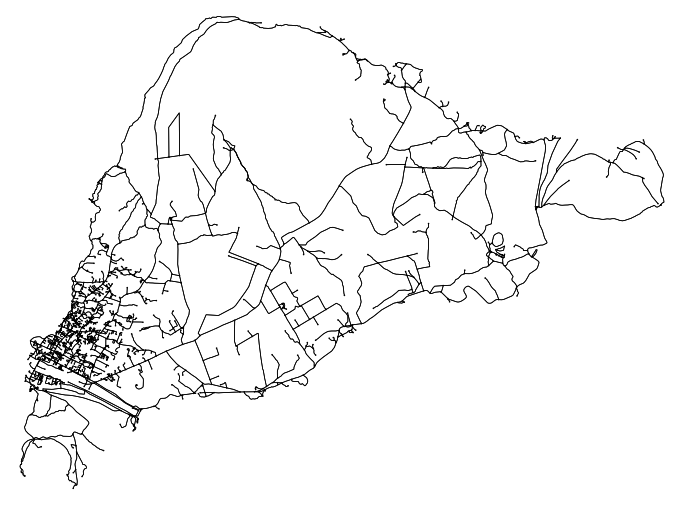

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
place_name = "Easter Island, Chile"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

fig_kwargs = dict(figsize=(12, 12), bgcolor='white', node_color='k', node_size=2.5, node_alpha=None, node_edgecolor='none', 
                  node_zorder=1, edge_color='k', edge_linewidth=0.75, edge_alpha=None, show=True, close=False, save=False, 
                  filepath=None, dpi=300, bbox=None)

fig, ax = ox.plot_graph(graph, **fig_kwargs)

# Save nodes and edges from the location
ox.io.save_graph_geopackage(graph, filepath="data/Day02/EasterIsland.gpkg")

# **Day 07:** Green

In [7]:
import ee
import geopandas as gpd

In [1]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AX4XfWg-sBZ62v9yznwDQlAFvg7KraOruSacwWlRSmdh-bd0RZk5tvu0lm4



Successfully saved authorization token.


In [9]:
geometry = gpd.read_file("data/Day05/easter_island_selected.shp")

In [11]:
dataset = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI')\
            .filterDate('2017-01-01', '2017-12-31')

In [12]:
colorized = dataset.select('NDVI');

In [16]:
from IPython.display import Image

# Extras

In [ ]:
import numpy as np
import xarray as xr
import cdsapi
import os

def request_info_from_copernicus(dataset_short_name, product_type, extent, time, day, month, year, path_folder, name_file):
    #start client
    c = cdsapi.Client()
    #check if folder is created
    if os.path.isdir(path_folder) == False:
        os.mkdir(path_folder)
    else:
        pass
    #start request
    c.retrieve(
        dataset_short_name,
        {
            'product_type': product_type,
            'format'      : 'grib',
            'area'        : extent,
            'variable'    : variables,
            'time'        : time,
            'day'         : day,
            'month'       : month,
            'year'        : year,
        },
        path_folder+name_file)
    return

In [ ]:
dataset_short_name = 'reanalysis-era5-single-levels'
product_type       = 'reanalysis'
extent             = [-33.5, -72.5, -35.5, -69.5] # N, W, S, E
variables          = ['total_precipitation',]
time               = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00',]
day                = ['0'+str(n) if n<9 else str(n) for n in np.linspace(1, 31, 31, dtype=int)]
month              = ['0'+str(n) if n<9 else str(n) for n in np.linspace(1, 12, 12, dtype=int)]
year               = [str(n) for n in np.linspace(2016, 2020, 5, dtype=int)]
path_folder        = 'data/Day05/'

for y in year:
    for m in month:
        print(f"started year: {y}, month: {m}")
        name_file          = 'precipitacion_total_VIregion'+y+m+'.grib'
        request_info_from_copernicus(dataset_short_name, product_type, extent, time, day, month, [y], path_folder, name_file)
        print(f"finished year: {y}, month: {m}")